# PyEddyTracker - EAC-003 QUIET ZONE ASSESSMENT
## CONTENTS;
### 1. Load in data
This notebook will be used to investigate what is happening in the EAC extension of EAC-003 in terms of mesoscale eddy features. 

The py-eddy-tracker seems to show eddies that move poleward from the separation region, before dissipating around 35-40S. I would like to animate, or at least plot interactively, the velocities coinciding with the eddy tracks to see whether this is indeed the case. 

In [1]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange
import xarray as xr

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations

import xarray as xr
import glob
from netCDF4 import Dataset
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

In [13]:
import numpy as np
import pandas as pd

In [2]:
# set paths to model output
adt_datapath = '/home/johnr/utas/Documents/phd_folder/gadi_notebooks/data/subsetted_data/'
# adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'

## SRM
eac_003 = adt_datapath + 'eac-rg-dt.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac-rg-dt.nc'
## PARENTs
om2_01 = adt_datapath + 'om2-rg-dt.nc' 
# OBS
aviso = adt_datapath + 'avisodt.nc'
# set paths to track files
aviso_track = adt_datapath + '/track_files/avisodt/'
eac_track = adt_datapath + '/track_files/eac-rg-dt/'
sthpac_track = adt_datapath + '/track_files/sthpac-rg-dt/'
om2_track = adt_datapath + '/track_files/om2-rg-dt/' 

In [ ]:
asdf

### Open ssh files and plot
Load SSH Data 

In [3]:
plt.figure(figsize=(18,4))
aviso_ssh = xr.open_dataarray(aviso)
eac_ssh = xr.open_dataarray(eac_003)
sthpac_ssh = xr.open_dataarray(sthpac_01)
om2_ssh = xr.open_dataarray(om2_01)

ssh_ls = [om2_ssh, sthpac_ssh, eac_ssh, aviso_ssh]

# for i, ssh in enumerate(ssh_ls):
#     plt.subplot(1,4,i+1)
#     ssh.isel(time=1000).plot()

<Figure size 1800x400 with 0 Axes>

In [4]:
for ssh in ssh_ls:
    print(ssh.time.max().values)

2019-12-31T12:00:00.000000000
2018-12-31 12:00:00
2017-12-31 12:00:00
2020-06-03T00:00:00.000000000


**Plot EAC-003 Interactively**

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [6]:
def plot_eac_ssh(i):
    fig, ax = plt.subplots(figsize=(4,4))
    eac_ssh.isel(time=i).plot(ax=ax)

In [7]:
import ipywidgets
ipywidgets.__version__

'8.1.1'

In [8]:
interact(plot_eac_ssh, i=(0, len(eac_ssh.time), 1))

interactive(children=(IntSlider(value=4991, description='i', max=9982), Output()), _dom_classes=('widget-inter…

<function __main__.plot_eac_ssh(i)>

Okay, so it's great that we've got the interactive functionality working with vscode now. Let's load in the tracking files for eac-003 and try to overlay these maps

In [9]:
eac_tracks = TrackEddiesObservations.load_file(eac_track + 'Anticyclonic.nc')
print(eac_tracks)

/mnt/c/Users/johnr/OneDrive - University of Tasmania/Documents/phd_folder/gadi_notebooks/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 291599 observations from 14642 to 24623 (9982 days, ~29 obs/day)
    |   Speed area      : 0.26 Mkm²/day
    |   Effective area  : 0.36 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.61     15.02     14.20     11.19      8.33     26.56     24.08
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      8.75     38.14     23.95     13.15     10.26      5.74      0.02
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      6.31     26.99     21.90     16.15     16.69     11.92      0.04
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00 

## Plotting
I want to plot SLA, under the eddy track as it moves with each timestep, keeping the earlier tracks present.

In [10]:
def extract_and_plot_eddy(i):
    eddy = eac_tracks_long.extract_ids([i])
    eddy_f = eddy
    eddy_f.position_filter(median_half_window=1, loess_half_window=5)
    fig, ax = plt.subplots()
    ax.set_xlim(eac_ssh['lon'].min().values, eac_ssh['lon'].max().values)
    ax.set_ylim(eac_ssh['lat'].min().values, eac_ssh['lat'].max().values)
    eddy.plot(ax, color='r', lw=0.5)
    eddy_f.scatter(ax, 'n', cmap='jet', s=80)

I need to be able to print all the track ids such that I can click through these. 

In [27]:
eac_tracks_long = eac_tracks.extract_with_length((200,300))
print(eac_tracks_long)

    | 26011 observations from 14642 to 24623 (9982 days, ~3 obs/day)
    |   Speed area      : 0.03 Mkm²/day
    |   Effective area  : 0.05 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.17      4.40      6.54      7.04      6.16     26.75     48.93
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      2.06     23.14     27.07     18.53     18.92     10.29      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      1.32      9.19     16.42     18.92     28.06     26.06      0.03
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00   

/mnt/c/Users/johnr/OneDrive - University of Tasmania/Documents/phd_folder/gadi_notebooks/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


In [28]:
# get unique track ids
track_ids = np.unique(eac_tracks_long.tracks)
len(track_ids)

108

In [29]:
interact(extract_and_plot_eddy, i=track_ids)

interactive(children=(Dropdown(description='i', options=(19, 44, 235, 343, 363, 454, 479, 482, 500, 843, 854, …

<function __main__.extract_and_plot_eddy(i)>

Okay, so at least I'm now able to extract the ids of the eddies and plot these interactively. Now what I want is to find those eddies between 100 and 200 days that exist in the separation/northern eac-extension region but then seem to surprisingly dissipate. So, let's get a box of that location - let's do this by plotting the tracks so we know exactly where to draw the box. 

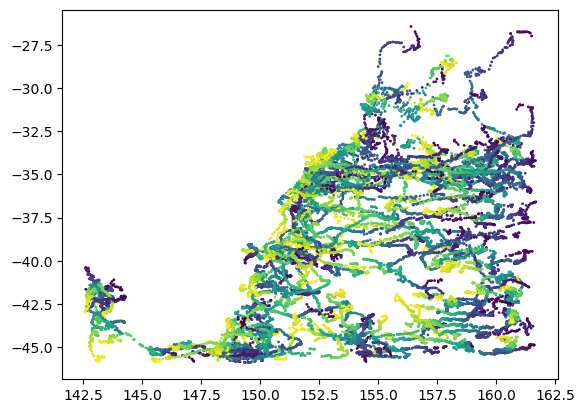

In [30]:
fig, ax = plt.subplots()
eac_tracks_long.scatter(ax, 'age', s=1)

Okay so that's something else that's good to be aware of. The OM2 data start at Jan 1st, 1990, the STHPAC data start on Feb 1st, 1990 whilst the EAC data start the day after on Feb 2nd, 1990. 

This should impact anything too much though. 